# Часть 1. Подготовка данных

## Создание датакласса


In [77]:
import os
import shutil
import random
from PIL import Image
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns

from tqdm import tqdm
import zipfile

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [5]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root, split, classes, transform=None):
        """
        root: путь к tiny-imagenet-200
        split: 'train' или 'val'
        classes: список из 10 wnid классов
        """
        self.root = root
        self.split = split
        self.transform = transform
        self.classes = classes
        self.class_to_idx = {cls: i for i, cls in enumerate(classes)}
        self.samples = []

        if split == "train":
            for cls in classes:
                img_dir = os.path.join(root, "train", cls, "images")
                for img_name in os.listdir(img_dir):
                    self.samples.append(
                        (os.path.join(img_dir, img_name), self.class_to_idx[cls])
                    )

        elif split == "test":
            test_img_dir = os.path.join(root, "test", "images")
            for img_name in os.listdir(test_img_dir):
                self.samples.append(
                    (os.path.join(test_img_dir, img_name), -1)  # фиктивная метка
                )

        
        elif split == "val":
            val_img_dir = os.path.join(root, "val", "images")
            ann_file = os.path.join(root, "val", "val_annotations.txt")

            img_to_cls = {}
            with open(ann_file) as f:
                for line in f:
                    img, cls = line.split()[:2]
                    if cls in self.class_to_idx:
                        img_to_cls[img] = self.class_to_idx[cls]

            for img, label in img_to_cls.items():
                self.samples.append(
                    (os.path.join(val_img_dir, img), label)
                )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

classes = [
    'n02106662',
    'n01882714',
    'n02124075',
    'n02132136',
    'n02395406',
    'n02410509',
    'n02415577',
    'n02423022',
    'n02480495',
    'n02509815'
]

root = "/kaggle/input/tiny-imagenet-zip/tiny-imagenet-200"
train_dataset = TinyImageNetDataset(root, 'train', classes, train_transform)
val_dataset   = TinyImageNetDataset(root, 'val',   classes, val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False, num_workers=4)

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(val_dataset)}")
print(f"Классов: {len(train_dataset.classes)}")

Train size: 5000
Test size: 500
Классов: 10


# Часть 2: Базовая архитектура ResNet18

## 2.1. Реализация Basic Block

In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, activation="relu"):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.activation = self._get_activation(activation)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

    def _get_activation(self, name):
        match name.lower():
            case "relu":
                return nn.ReLU(inplace=True)
            case "leakyrelu":
                return nn.LeakyReLU(inplace=True)
            case "elu":
                return nn.ELU(inplace=True)
            case "gelu":
                return nn.GELU()
            case _:
                raise ValueError(f"Unknown activation: {name}")

    def forward(self, x):
        identity = x

        out = self.activation(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out = out + identity
        out = self.activation(out)

        return out


## 2.2. Реализация ResNet18

In [8]:
import torch
import torch.nn as nn

class ResNet18(nn.Module):
    def __init__(self, num_classes=10, activation="relu", use_maxpool=True):
        super().__init__()

        # Stem
        self.conv1 = nn.Conv2d(
            3, 64,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.activation = self._get_activation(activation)

        self.maxpool = (
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            if use_maxpool else nn.Identity()
        )

        # Слой 1: 64 каналов
        self.block1_1 = BasicBlock(64, 64, stride=1, activation=activation)
        self.block1_2 = BasicBlock(64, 64, stride=1, activation=activation)

        # Слой 2: 128 каналов
        self.block2_1 = BasicBlock(64, 128, stride=2, activation=activation)
        self.block2_2 = BasicBlock(128, 128, stride=1, activation=activation)

        # Слой 3: 256 каналов
        self.block3_1 = BasicBlock(128, 256, stride=2, activation=activation)
        self.block3_2 = BasicBlock(256, 256, stride=1, activation=activation)

        # Слой 4: 512 каналов
        self.block4_1 = BasicBlock(256, 512, stride=2, activation=activation)
        self.block4_2 = BasicBlock(512, 512, stride=1, activation=activation)

        # Голова
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _get_activation(self, name):
        match name.lower():
            case "relu":
                return nn.ReLU(inplace=True)
            case "leakyrelu":
                return nn.LeakyReLU(inplace=True)
            case "elu":
                return nn.ELU(inplace=True)
            case "gelu":
                return nn.GELU()
            case _:
                raise ValueError(f"Unknown activation: {name}")

    def forward(self, x):
        # Stem
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        # Слой 1
        x = self.block1_1(x)
        x = self.block1_2(x)

        # Слой 2
        x = self.block2_1(x)
        x = self.block2_2(x)

        # Слой 3
        x = self.block3_1(x)
        x = self.block3_2(x)

        # Слой 4
        x = self.block4_1(x)
        x = self.block4_2(x)

        # Голова
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [9]:
model = ResNet18()
test_matrix = torch.randn(1, 3, 128, 128)
result = model(test_matrix)
print(result.shape)

total_params = sum(p.numel() for p in model.parameters())
print(f" Всего параметров: {total_params:,}")

torch.Size([1, 10])
 Всего параметров: 11,173,962


Параметров слишком много. Требуется до 5_000_000 => число каналов в 4 слое надо уменьшить

In [10]:
import torch
import torch.nn as nn

class ResNet18(nn.Module):
    def __init__(self, num_classes=10, activation="relu", use_maxpool=True):
        super().__init__()

        # Stem
        self.conv1 = nn.Conv2d(
            3, 64,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.activation = self._get_activation(activation)

        self.maxpool = (
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            if use_maxpool else nn.Identity()
        )

        # Слой 1: 64 каналов
        self.block1_1 = BasicBlock(64, 64, stride=1, activation=activation)
        self.block1_2 = BasicBlock(64, 64, stride=1, activation=activation)

        # Слой 2: 128 каналов
        self.block2_1 = BasicBlock(64, 128, stride=2, activation=activation)
        self.block2_2 = BasicBlock(128, 128, stride=1, activation=activation)

        # Слой 3: 256 каналов
        self.block3_1 = BasicBlock(128, 256, stride=2, activation=activation)
        self.block3_2 = BasicBlock(256, 256, stride=1, activation=activation)

        # Слой 4: 256 каналов
        self.block4_1 = BasicBlock(256, 256, stride=2, activation=activation)
        self.block4_2 = BasicBlock(256, 256, stride=1, activation=activation)

        # Голова
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _get_activation(self, name):
        match name.lower():
            case "relu":
                return nn.ReLU(inplace=True)
            case "leakyrelu":
                return nn.LeakyReLU(inplace=True)
            case "elu":
                return nn.ELU(inplace=True)
            case "gelu":
                return nn.GELU()
            case _:
                raise ValueError(f"Unknown activation: {name}")

    def forward(self, x):
        # Stem
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        # Слой 1
        x = self.block1_1(x)
        x = self.block1_2(x)

        # Слой 2
        x = self.block2_1(x)
        x = self.block2_2(x)

        # Слой 3
        x = self.block3_1(x)
        x = self.block3_2(x)

        # Слой 4
        x = self.block4_1(x)
        x = self.block4_2(x)

        # Голова
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [11]:
model = ResNet18()
test_matrix = torch.randn(1, 3, 128, 128)
result = model(test_matrix)
print(result.shape)

total_params = sum(p.numel() for p in model.parameters())
print(f" Всего параметров: {total_params:,}")

torch.Size([1, 10])
 Всего параметров: 5,205,066


5_205_066 почти 5_000_000, что хорошо

## 2.4. Скрипт обучения

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet18(
    num_classes=10,
    activation="relu",
    use_maxpool=True
).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001
)

In [13]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()

    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Train", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total

    return avg_loss, accuracy

In [14]:
@torch.no_grad()
def validate_one_epoch(model, loader, criterion, device):
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Val", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        total_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total

    return avg_loss, accuracy


In [24]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, model_name, num_epochs=20):
    """
    Обучает модель и возвращает метрики для визуализации.

    Возвращает:
        train_losses, val_losses, train_accs, val_accs
    """
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_val_acc = 0.0
    
    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch [{epoch}/{num_epochs}]")

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

        # Validation
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

        # Сохраняем метрики
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
            f"|| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_name)
            print(f" Сохранена лучшая модель с точностью {val_acc*100:.2f}%")

    return train_losses, val_losses, train_accs, val_accs

In [25]:
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, device, 'resnet18.pth')


Epoch [1/20]


Train Loss: 1.6352 | Train Acc: 0.4398 || Val Loss: 1.6724 | Val Acc: 0.4140
 Сохранена лучшая модель с точностью 41.40%

Epoch [2/20]


Train Loss: 1.5128 | Train Acc: 0.4762 || Val Loss: 1.6088 | Val Acc: 0.4380
 Сохранена лучшая модель с точностью 43.80%

Epoch [3/20]


Train Loss: 1.3767 | Train Acc: 0.5258 || Val Loss: 1.5976 | Val Acc: 0.4520
 Сохранена лучшая модель с точностью 45.20%

Epoch [4/20]


Train Loss: 1.2678 | Train Acc: 0.5672 || Val Loss: 1.4039 | Val Acc: 0.5240
 Сохранена лучшая модель с точностью 52.40%

Epoch [5/20]


Train Loss: 1.1113 | Train Acc: 0.6272 || Val Loss: 1.5900 | Val Acc: 0.5120

Epoch [6/20]


Train Loss: 0.9646 | Train Acc: 0.6738 || Val Loss: 1.4781 | Val Acc: 0.5240

Epoch [7/20]


Train Loss: 0.7709 | Train Acc: 0.7326 || Val Loss: 1.7240 | Val Acc: 0.5020

Epoch [8/20]


Train Loss: 0.6121 | Train Acc: 0.7884 || Val Loss: 1.6717 | Val Acc: 0.5180

Epoch [9/20]


Train Loss: 0.4300 | Train Acc: 0.8554 || Val Loss: 1.8042 | Val Acc: 0.5240

Epoch [10/20]


Train Loss: 0.3202 | Train Acc: 0.8936 || Val Loss: 2.1345 | Val Acc: 0.5120

Epoch [11/20]


Train Loss: 0.2536 | Train Acc: 0.9178 || Val Loss: 2.1892 | Val Acc: 0.5080

Epoch [12/20]


Train Loss: 0.2099 | Train Acc: 0.9306 || Val Loss: 2.1027 | Val Acc: 0.5000

Epoch [13/20]


Train Loss: 0.1775 | Train Acc: 0.9452 || Val Loss: 2.2438 | Val Acc: 0.5240

Epoch [14/20]


Train Loss: 0.1433 | Train Acc: 0.9526 || Val Loss: 2.3703 | Val Acc: 0.5040

Epoch [15/20]


Train Loss: 0.1637 | Train Acc: 0.9454 || Val Loss: 2.2350 | Val Acc: 0.5260
 Сохранена лучшая модель с точностью 52.60%

Epoch [16/20]


Train Loss: 0.1385 | Train Acc: 0.9540 || Val Loss: 2.3784 | Val Acc: 0.5320
 Сохранена лучшая модель с точностью 53.20%

Epoch [17/20]


Train Loss: 0.1173 | Train Acc: 0.9618 || Val Loss: 2.4310 | Val Acc: 0.5300

Epoch [18/20]


Train Loss: 0.1002 | Train Acc: 0.9686 || Val Loss: 2.6253 | Val Acc: 0.5080

Epoch [19/20]


Train Loss: 0.1075 | Train Acc: 0.9644 || Val Loss: 2.6584 | Val Acc: 0.4900

Epoch [20/20]


Train Loss: 0.1193 | Train Acc: 0.9614 || Val Loss: 2.7723 | Val Acc: 0.4920


## 2.5 Визуализация базовых результатов

In [26]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    """
    Визуализирует кривые обучения для Loss и Accuracy.
    
    train_losses, val_losses: списки loss на каждой эпохе
    train_accs, val_accs: списки accuracy на каждой эпохе
    """
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Train Accuracy", marker='o')
    plt.plot(epochs, val_accs, label="Validation Accuracy", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

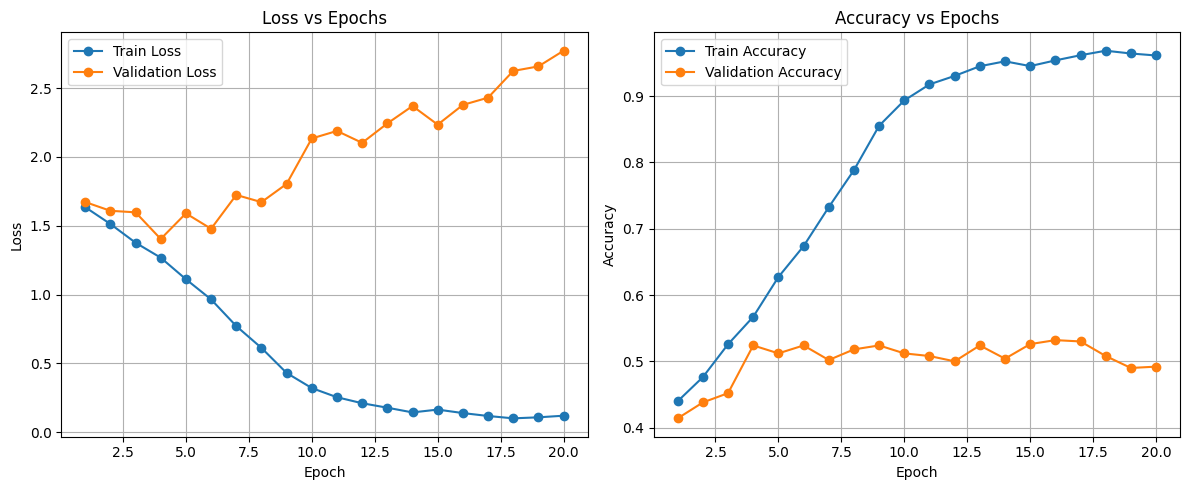

In [27]:
plot_training_curves(train_losses, val_losses, train_accs, val_accs)

Переобучились очень сильно, что нехорошо

# Часть 3: Поэтапная оптимизация модели

## 3.1: Оптимизация количества каналов

### Вариант A: 32 → 64 → 128 → 256 каналов

In [28]:
import torch
import torch.nn as nn

class ResNet18_Version_A(nn.Module):
    def __init__(self, num_classes=10, activation="relu", use_maxpool=True):
        super().__init__()

        # Stem
        self.conv1 = nn.Conv2d(
            3, 32,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(32)
        self.activation = self._get_activation(activation)

        self.maxpool = (
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            if use_maxpool else nn.Identity()
        )

        # Слой 1: 32 каналов
        self.block1_1 = BasicBlock(32, 32, stride=1, activation=activation)
        self.block1_2 = BasicBlock(32, 32, stride=1, activation=activation)

        # Слой 2: 64 каналов
        self.block2_1 = BasicBlock(32, 64, stride=2, activation=activation)
        self.block2_2 = BasicBlock(64, 64, stride=1, activation=activation)

        # Слой 3: 128 каналов
        self.block3_1 = BasicBlock(64, 128, stride=2, activation=activation)
        self.block3_2 = BasicBlock(128, 128, stride=1, activation=activation)

        # Слой 4: 256 каналов
        self.block4_1 = BasicBlock(128, 256, stride=2, activation=activation)
        self.block4_2 = BasicBlock(256, 256, stride=1, activation=activation)

        # Голова
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _get_activation(self, name):
        match name.lower():
            case "relu":
                return nn.ReLU(inplace=True)
            case "leakyrelu":
                return nn.LeakyReLU(inplace=True)
            case "elu":
                return nn.ELU(inplace=True)
            case "gelu":
                return nn.GELU()
            case _:
                raise ValueError(f"Unknown activation: {name}")

    def forward(self, x):
        # Stem
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        # Слой 1
        x = self.block1_1(x)
        x = self.block1_2(x)

        # Слой 2
        x = self.block2_1(x)
        x = self.block2_2(x)

        # Слой 3
        x = self.block3_1(x)
        x = self.block3_2(x)

        # Слой 4
        x = self.block4_1(x)
        x = self.block4_2(x)

        # Голова
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [29]:
model_A = ResNet18_Version_A(
    num_classes=10,
    activation="relu",
    use_maxpool=True
).to(device)

optimizer_a = torch.optim.Adam(model_A.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses_a, val_losses_a, train_accs_a, val_accs_a = train_model(model_A, train_loader, val_loader, criterion, optimizer_a, device, 'model_a.pth')


Epoch [1/20]


Train Loss: 2.1337 | Train Acc: 0.2422 || Val Loss: 2.0385 | Val Acc: 0.2680
 Сохранена лучшая модель с точностью 26.80%

Epoch [2/20]


Train Loss: 1.9169 | Train Acc: 0.3308 || Val Loss: 1.8638 | Val Acc: 0.3540
 Сохранена лучшая модель с точностью 35.40%

Epoch [3/20]


Train Loss: 1.7583 | Train Acc: 0.3884 || Val Loss: 1.9352 | Val Acc: 0.3680
 Сохранена лучшая модель с точностью 36.80%

Epoch [4/20]


Train Loss: 1.6260 | Train Acc: 0.4318 || Val Loss: 1.7201 | Val Acc: 0.4240
 Сохранена лучшая модель с точностью 42.40%

Epoch [5/20]


Train Loss: 1.4944 | Train Acc: 0.4862 || Val Loss: 1.6493 | Val Acc: 0.4420
 Сохранена лучшая модель с точностью 44.20%

Epoch [6/20]


Train Loss: 1.3754 | Train Acc: 0.5268 || Val Loss: 1.5430 | Val Acc: 0.4720
 Сохранена лучшая модель с точностью 47.20%

Epoch [7/20]


Train Loss: 1.2304 | Train Acc: 0.5776 || Val Loss: 1.3676 | Val Acc: 0.5300
 Сохранена лучшая модель с точностью 53.00%

Epoch [8/20]


Train Loss: 1.0828 | Train Acc: 0.6306 || Val Loss: 1.3864 | Val Acc: 0.5300

Epoch [9/20]


Train Loss: 0.9322 | Train Acc: 0.6776 || Val Loss: 1.4832 | Val Acc: 0.5280

Epoch [10/20]


Train Loss: 0.7502 | Train Acc: 0.7408 || Val Loss: 1.5437 | Val Acc: 0.5160

Epoch [11/20]


Train Loss: 0.5670 | Train Acc: 0.8146 || Val Loss: 1.6315 | Val Acc: 0.5160

Epoch [12/20]


Train Loss: 0.4066 | Train Acc: 0.8648 || Val Loss: 1.9290 | Val Acc: 0.5080

Epoch [13/20]


Train Loss: 0.3174 | Train Acc: 0.8928 || Val Loss: 1.9209 | Val Acc: 0.5160

Epoch [14/20]


Train Loss: 0.2620 | Train Acc: 0.9146 || Val Loss: 1.8538 | Val Acc: 0.5500
 Сохранена лучшая модель с точностью 55.00%

Epoch [15/20]


Train Loss: 0.1909 | Train Acc: 0.9378 || Val Loss: 2.1406 | Val Acc: 0.5500

Epoch [16/20]


Train Loss: 0.1881 | Train Acc: 0.9360 || Val Loss: 2.3291 | Val Acc: 0.4800

Epoch [17/20]


Train Loss: 0.1813 | Train Acc: 0.9388 || Val Loss: 2.2214 | Val Acc: 0.5040

Epoch [18/20]


Train Loss: 0.1114 | Train Acc: 0.9630 || Val Loss: 2.3529 | Val Acc: 0.5160

Epoch [19/20]


Train Loss: 0.1686 | Train Acc: 0.9460 || Val Loss: 2.5338 | Val Acc: 0.4920

Epoch [20/20]


Train Loss: 0.1108 | Train Acc: 0.9652 || Val Loss: 2.6035 | Val Acc: 0.4980


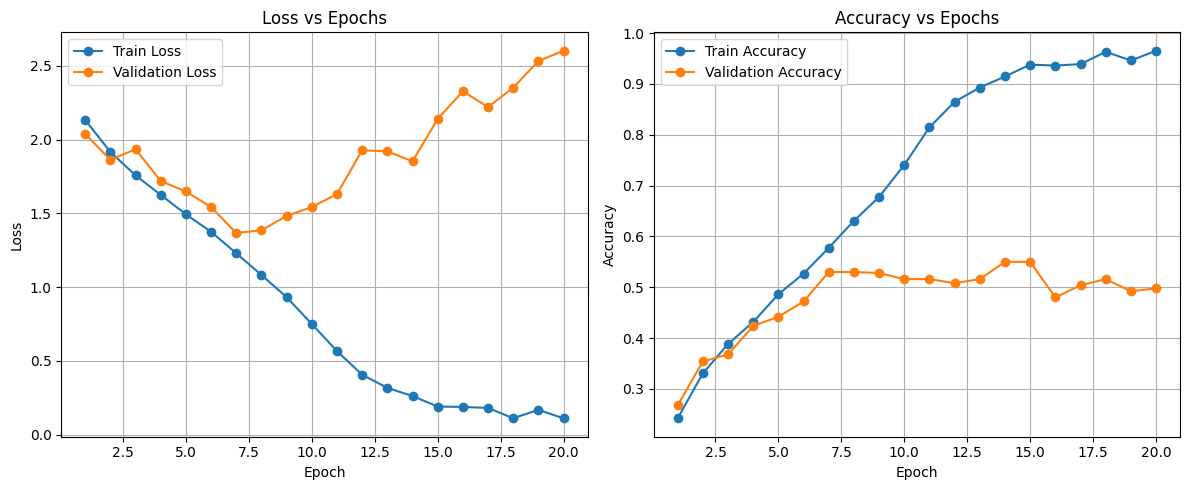

In [30]:
plot_training_curves(train_losses_a, val_losses_a, train_accs_a, val_accs_a)

In [31]:
total_params_a = sum(p.numel() for p in model_A.parameters())
print(f" Всего параметров: {total_params_a:,}")

 Всего параметров: 2,797,610


Все так же сильное переобучение

### Вариант B: 64 → 128 → 256 каналов (без 4-го слоя)

In [45]:
import torch
import torch.nn as nn

class ResNet18_Version_B(nn.Module):
    def __init__(self, num_classes=10, activation="relu", use_maxpool=True):
        super().__init__()

        # Stem
        self.conv1 = nn.Conv2d(
            3, 64,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.activation = self._get_activation(activation)

        self.maxpool = (
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            if use_maxpool else nn.Identity()
        )

        # Слой 1: 32 каналов
        self.block1_1 = BasicBlock(64, 64, stride=1, activation=activation)
        self.block1_2 = BasicBlock(64, 64, stride=1, activation=activation)

        # Слой 2: 64 каналов
        self.block2_1 = BasicBlock(64, 128, stride=2, activation=activation)
        self.block2_2 = BasicBlock(128, 128, stride=1, activation=activation)

        # Слой 3: 128 каналов
        self.block3_1 = BasicBlock(128, 256, stride=2, activation=activation)
        self.block3_2 = BasicBlock(256, 256, stride=1, activation=activation)

        # Голова
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _get_activation(self, name):
        match name.lower():
            case "relu":
                return nn.ReLU(inplace=True)
            case "leakyrelu":
                return nn.LeakyReLU(inplace=True)
            case "elu":
                return nn.ELU(inplace=True)
            case "gelu":
                return nn.GELU()
            case _:
                raise ValueError(f"Unknown activation: {name}")

    def forward(self, x):
        # Stem
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        # Слой 1
        x = self.block1_1(x)
        x = self.block1_2(x)

        # Слой 2
        x = self.block2_1(x)
        x = self.block2_2(x)

        # Слой 3
        x = self.block3_1(x)
        x = self.block3_2(x)

        # Голова
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [46]:
model_B = ResNet18_Version_B(
    num_classes=10,
    activation="relu",
    use_maxpool=True
).to(device)

optimizer_b = torch.optim.Adam(model_B.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses_b, val_losses_b, train_accs_b, val_accs_b = train_model(model_B, train_loader, val_loader, criterion, optimizer_b, device, 'model_b.pth')


Epoch [1/20]


Train Loss: 2.1655 | Train Acc: 0.2310 || Val Loss: 2.0023 | Val Acc: 0.3160
 Сохранена лучшая модель с точностью 31.60%

Epoch [2/20]


Train Loss: 1.9245 | Train Acc: 0.3290 || Val Loss: 1.8529 | Val Acc: 0.3780
 Сохранена лучшая модель с точностью 37.80%

Epoch [3/20]


Train Loss: 1.7576 | Train Acc: 0.3902 || Val Loss: 1.8140 | Val Acc: 0.3500

Epoch [4/20]


Train Loss: 1.6268 | Train Acc: 0.4448 || Val Loss: 1.5796 | Val Acc: 0.4540
 Сохранена лучшая модель с точностью 45.40%

Epoch [5/20]


Train Loss: 1.4976 | Train Acc: 0.4912 || Val Loss: 1.8120 | Val Acc: 0.4160

Epoch [6/20]


Train Loss: 1.4004 | Train Acc: 0.5218 || Val Loss: 1.4456 | Val Acc: 0.5320
 Сохранена лучшая модель с точностью 53.20%

Epoch [7/20]


Train Loss: 1.3140 | Train Acc: 0.5572 || Val Loss: 1.4368 | Val Acc: 0.5140

Epoch [8/20]


Train Loss: 1.1960 | Train Acc: 0.6032 || Val Loss: 1.4474 | Val Acc: 0.5160

Epoch [9/20]


Train Loss: 1.1175 | Train Acc: 0.6170 || Val Loss: 1.3421 | Val Acc: 0.5680
 Сохранена лучшая модель с точностью 56.80%

Epoch [10/20]


Train Loss: 1.0217 | Train Acc: 0.6584 || Val Loss: 1.2900 | Val Acc: 0.5740
 Сохранена лучшая модель с точностью 57.40%

Epoch [11/20]


Train Loss: 0.9294 | Train Acc: 0.6824 || Val Loss: 1.4411 | Val Acc: 0.5420

Epoch [12/20]


Train Loss: 0.8207 | Train Acc: 0.7250 || Val Loss: 1.2984 | Val Acc: 0.5660

Epoch [13/20]


Train Loss: 0.7015 | Train Acc: 0.7636 || Val Loss: 1.4504 | Val Acc: 0.5420

Epoch [14/20]


Train Loss: 0.5737 | Train Acc: 0.8062 || Val Loss: 1.4008 | Val Acc: 0.5840
 Сохранена лучшая модель с точностью 58.40%

Epoch [15/20]


Train Loss: 0.4844 | Train Acc: 0.8334 || Val Loss: 1.5308 | Val Acc: 0.5580

Epoch [16/20]


Train Loss: 0.3641 | Train Acc: 0.8780 || Val Loss: 1.8502 | Val Acc: 0.5220

Epoch [17/20]


Train Loss: 0.2844 | Train Acc: 0.9080 || Val Loss: 1.7725 | Val Acc: 0.5700

Epoch [18/20]


Train Loss: 0.2680 | Train Acc: 0.9096 || Val Loss: 2.0668 | Val Acc: 0.5360

Epoch [19/20]


Train Loss: 0.1961 | Train Acc: 0.9364 || Val Loss: 1.7558 | Val Acc: 0.5580

Epoch [20/20]


Train Loss: 0.1870 | Train Acc: 0.9394 || Val Loss: 1.8057 | Val Acc: 0.5800


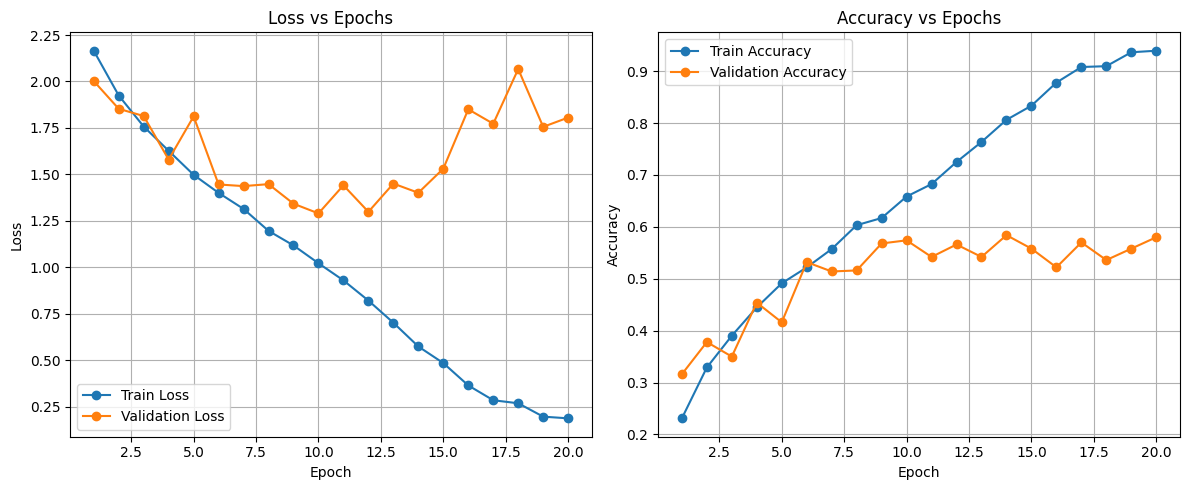

In [47]:
plot_training_curves(train_losses_b, val_losses_b, train_accs_b, val_accs_b)

In [48]:
total_params_b = sum(p.numel() for p in model_B.parameters())
print(f" Всего параметров: {total_params_b:,}")

 Всего параметров: 2,777,674


Модель без 4-го слоя показала лучше результат на тесте, но так же переобучилась. По размеру - меньше на 20_000 параметров

## 3.2 Эксперименты с количеством residual блоков

### Вариант A: [1, 1, 1, 1] - по 1 блоку в каждом слое (мелкая сеть)

In [82]:
import torch
import torch.nn as nn

class ResNet18_Version_BA(nn.Module):
    def __init__(self, num_classes=10, activation="relu", use_maxpool=True):
        super().__init__()

        # Stem
        self.conv1 = nn.Conv2d(
            3, 64,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.activation = self._get_activation(activation)

        self.maxpool = (
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            if use_maxpool else nn.Identity()
        )

        # Слой 1: 32 каналов
        self.block1_1 = BasicBlock(64, 64, stride=1, activation=activation)

        # Слой 2: 64 каналов
        self.block2_1 = BasicBlock(64, 128, stride=2, activation=activation)

        # Слой 3: 128 каналов
        self.block3_1 = BasicBlock(128, 256, stride=2, activation=activation)

        # Голова
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _get_activation(self, name):
        match name.lower():
            case "relu":
                return nn.ReLU(inplace=True)
            case "leakyrelu":
                return nn.LeakyReLU(inplace=True)
            case "elu":
                return nn.ELU(inplace=True)
            case "gelu":
                return nn.GELU()
            case _:
                raise ValueError(f"Unknown activation: {name}")

    def forward(self, x):
        # Stem
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        # Слой 1
        x = self.block1_1(x)

        # Слой 2
        x = self.block2_1(x)

        # Слой 3
        x = self.block3_1(x)

        # Голова
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [83]:
model_BA = ResNet18_Version_BA(
    num_classes=10,
    activation="relu",
    use_maxpool=True
).to(device)

optimizer_ba = torch.optim.Adam(model_BA.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses_ba, val_losses_ba, train_accs_ba, val_accs_ba = train_model(model_BA, train_loader, val_loader, criterion, optimizer_ba, device, 'model_ba.pth')


Epoch [1/20]


Train Loss: 2.1272 | Train Acc: 0.2386 || Val Loss: 2.0701 | Val Acc: 0.3080
 Сохранена лучшая модель с точностью 30.80%

Epoch [2/20]


Train Loss: 1.8565 | Train Acc: 0.3602 || Val Loss: 1.8002 | Val Acc: 0.3560
 Сохранена лучшая модель с точностью 35.60%

Epoch [3/20]


Train Loss: 1.6777 | Train Acc: 0.4302 || Val Loss: 1.7154 | Val Acc: 0.4160
 Сохранена лучшая модель с точностью 41.60%

Epoch [4/20]


Train Loss: 1.5532 | Train Acc: 0.4778 || Val Loss: 1.6489 | Val Acc: 0.4600
 Сохранена лучшая модель с точностью 46.00%

Epoch [5/20]


Train Loss: 1.4262 | Train Acc: 0.5160 || Val Loss: 1.4202 | Val Acc: 0.5080
 Сохранена лучшая модель с точностью 50.80%

Epoch [6/20]


Train Loss: 1.3141 | Train Acc: 0.5548 || Val Loss: 1.5120 | Val Acc: 0.5120
 Сохранена лучшая модель с точностью 51.20%

Epoch [7/20]


Train Loss: 1.2320 | Train Acc: 0.5846 || Val Loss: 1.3580 | Val Acc: 0.5500
 Сохранена лучшая модель с точностью 55.00%

Epoch [8/20]


Train Loss: 1.1212 | Train Acc: 0.6286 || Val Loss: 1.5242 | Val Acc: 0.5000

Epoch [9/20]


Train Loss: 1.0362 | Train Acc: 0.6528 || Val Loss: 1.2710 | Val Acc: 0.5820
 Сохранена лучшая модель с точностью 58.20%

Epoch [10/20]


Train Loss: 0.9441 | Train Acc: 0.6862 || Val Loss: 1.2450 | Val Acc: 0.5900
 Сохранена лучшая модель с точностью 59.00%

Epoch [11/20]


Train Loss: 0.8327 | Train Acc: 0.7274 || Val Loss: 1.3416 | Val Acc: 0.5680

Epoch [12/20]


Train Loss: 0.7260 | Train Acc: 0.7548 || Val Loss: 1.3086 | Val Acc: 0.5880

Epoch [13/20]


Train Loss: 0.6083 | Train Acc: 0.8002 || Val Loss: 1.3546 | Val Acc: 0.6020
 Сохранена лучшая модель с точностью 60.20%

Epoch [14/20]


Train Loss: 0.4761 | Train Acc: 0.8458 || Val Loss: 1.3782 | Val Acc: 0.6400
 Сохранена лучшая модель с точностью 64.00%

Epoch [15/20]


Train Loss: 0.3892 | Train Acc: 0.8824 || Val Loss: 1.4429 | Val Acc: 0.5880

Epoch [16/20]


Train Loss: 0.3061 | Train Acc: 0.8982 || Val Loss: 1.5242 | Val Acc: 0.6060

Epoch [17/20]


Train Loss: 0.2425 | Train Acc: 0.9232 || Val Loss: 1.8991 | Val Acc: 0.5820

Epoch [18/20]


Train Loss: 0.2054 | Train Acc: 0.9336 || Val Loss: 2.0309 | Val Acc: 0.5520

Epoch [19/20]


Train Loss: 0.1795 | Train Acc: 0.9402 || Val Loss: 1.8555 | Val Acc: 0.5960

Epoch [20/20]


Train Loss: 0.1572 | Train Acc: 0.9482 || Val Loss: 1.7239 | Val Acc: 0.6100


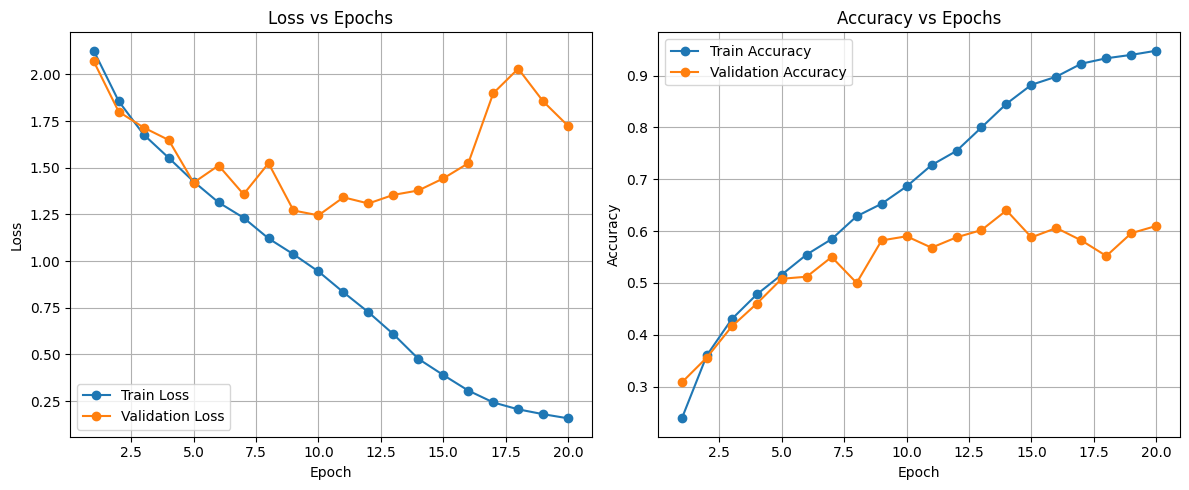

In [84]:
plot_training_curves(train_losses_ba, val_losses_ba, train_accs_ba, val_accs_ba)

In [85]:
total_params_ba = sum(p.numel() for p in model_BA.parameters())
print(f" Всего параметров: {total_params_ba:,}")

 Всего параметров: 1,227,594


Количество параметров уменьшили в 2 раза, модель все так же переобучается, но accuracy вырос с 58.4 до 64 О_О

### Вариант C: [3, 3, 3, 3] - по 3 блока в каждом слое (глубокая сеть)

In [55]:
import torch
import torch.nn as nn

class ResNet18_Version_BC(nn.Module):
    def __init__(self, num_classes=10, activation="relu", use_maxpool=True):
        super().__init__()

        # Stem
        self.conv1 = nn.Conv2d(
            3, 64,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.activation = self._get_activation(activation)

        self.maxpool = (
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            if use_maxpool else nn.Identity()
        )

        # Слой 1: 32 каналов
        self.block1_1 = BasicBlock(64, 64, stride=1, activation=activation)
        self.block1_2 = BasicBlock(64, 64, stride=1, activation=activation)
        self.block1_3 = BasicBlock(64, 64, stride=1, activation=activation)


        # Слой 2: 64 каналов
        self.block2_1 = BasicBlock(64, 128, stride=2, activation=activation)
        self.block2_2 = BasicBlock(128, 128, stride=1, activation=activation)
        self.block2_3 = BasicBlock(128, 128, stride=1, activation=activation)


        # Слой 3: 128 каналов
        self.block3_1 = BasicBlock(128, 256, stride=2, activation=activation)
        self.block3_2 = BasicBlock(256, 256, stride=1, activation=activation)
        self.block3_3 = BasicBlock(256, 256, stride=1, activation=activation)

        # Голова
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _get_activation(self, name):
        match name.lower():
            case "relu":
                return nn.ReLU(inplace=True)
            case "leakyrelu":
                return nn.LeakyReLU(inplace=True)
            case "elu":
                return nn.ELU(inplace=True)
            case "gelu":
                return nn.GELU()
            case _:
                raise ValueError(f"Unknown activation: {name}")

    def forward(self, x):
        # Stem
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        # Слой 1
        x = self.block1_1(x)
        x = self.block1_2(x)
        x = self.block1_3(x)

        # Слой 2
        x = self.block2_1(x)
        x = self.block2_2(x)
        x = self.block2_3(x)

        # Слой 3
        x = self.block3_1(x)
        x = self.block3_2(x)
        x = self.block3_3(x)

        # Голова
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [56]:
model_BC = ResNet18_Version_BC(
    num_classes=10,
    activation="relu",
    use_maxpool=True
).to(device)

optimizer_bc = torch.optim.Adam(model_BC.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses_bc, val_losses_bc, train_accs_bc, val_accs_bc = train_model(model_BC, train_loader, val_loader, criterion, optimizer_bc, device, 'model_bc.pth')


Epoch [1/20]


Train Loss: 2.2114 | Train Acc: 0.2170 || Val Loss: 2.0893 | Val Acc: 0.2620
 Сохранена лучшая модель с точностью 26.20%

Epoch [2/20]


Train Loss: 1.9727 | Train Acc: 0.3154 || Val Loss: 2.1991 | Val Acc: 0.2360

Epoch [3/20]


Train Loss: 1.8184 | Train Acc: 0.3656 || Val Loss: 1.8097 | Val Acc: 0.3760
 Сохранена лучшая модель с точностью 37.60%

Epoch [4/20]


Train Loss: 1.6828 | Train Acc: 0.4164 || Val Loss: 1.6483 | Val Acc: 0.4320
 Сохранена лучшая модель с точностью 43.20%

Epoch [5/20]


Train Loss: 1.5841 | Train Acc: 0.4490 || Val Loss: 1.6650 | Val Acc: 0.4420
 Сохранена лучшая модель с точностью 44.20%

Epoch [6/20]


Train Loss: 1.4741 | Train Acc: 0.4974 || Val Loss: 1.6988 | Val Acc: 0.4360

Epoch [7/20]


Train Loss: 1.3558 | Train Acc: 0.5382 || Val Loss: 1.5130 | Val Acc: 0.4720
 Сохранена лучшая модель с точностью 47.20%

Epoch [8/20]


Train Loss: 1.2544 | Train Acc: 0.5724 || Val Loss: 1.4637 | Val Acc: 0.5120
 Сохранена лучшая модель с точностью 51.20%

Epoch [9/20]


Train Loss: 1.1727 | Train Acc: 0.6060 || Val Loss: 1.5120 | Val Acc: 0.5060

Epoch [10/20]


Train Loss: 1.0603 | Train Acc: 0.6482 || Val Loss: 1.3994 | Val Acc: 0.5760
 Сохранена лучшая модель с точностью 57.60%

Epoch [11/20]


Train Loss: 0.9343 | Train Acc: 0.6816 || Val Loss: 1.3802 | Val Acc: 0.5640

Epoch [12/20]


Train Loss: 0.8359 | Train Acc: 0.7180 || Val Loss: 1.4553 | Val Acc: 0.5340

Epoch [13/20]


Train Loss: 0.6967 | Train Acc: 0.7650 || Val Loss: 1.4580 | Val Acc: 0.5660

Epoch [14/20]


Train Loss: 0.5799 | Train Acc: 0.7962 || Val Loss: 1.5987 | Val Acc: 0.5380

Epoch [15/20]


Train Loss: 0.4596 | Train Acc: 0.8446 || Val Loss: 1.6317 | Val Acc: 0.5700

Epoch [16/20]


Train Loss: 0.3512 | Train Acc: 0.8848 || Val Loss: 1.7894 | Val Acc: 0.5540

Epoch [17/20]


Train Loss: 0.3233 | Train Acc: 0.8900 || Val Loss: 1.7432 | Val Acc: 0.5720

Epoch [18/20]


Train Loss: 0.2358 | Train Acc: 0.9228 || Val Loss: 1.9262 | Val Acc: 0.5560

Epoch [19/20]


Train Loss: 0.2242 | Train Acc: 0.9256 || Val Loss: 1.9774 | Val Acc: 0.5460

Epoch [20/20]


Train Loss: 0.2090 | Train Acc: 0.9320 || Val Loss: 1.9555 | Val Acc: 0.5560


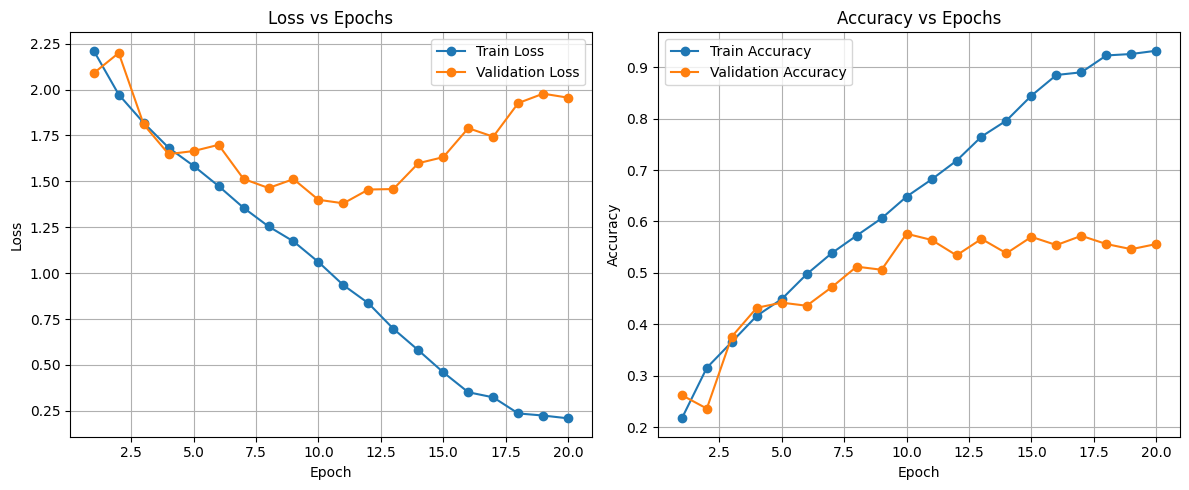

In [57]:
plot_training_curves(train_losses_bc, val_losses_bc, train_accs_bc, val_accs_bc)

In [58]:
total_params_bc = sum(p.numel() for p in model_BC.parameters())
print(f" Всего параметров: {total_params_bc:,}")

 Всего параметров: 4,327,754


Модель раздулась, качество не улучшилось, все так же переобучаемся

***В качестве лучшей возьмём Вариант А: [1, 1, 1] - по 1 блоку в каждом слое. Она достигла наибольшей val_accuracy. По скорости сходимости все модели примерно на одинаковых эпохах первый раз достигали отметки около 0.6 accuracy. + У нее должно быть больше capacity для дальнейших экспериментов***

## 3.3: Эксперименты с функциями активации

### Вариант B: LeakyReLU

In [64]:
model_BAB = ResNet18_Version_BA(
    num_classes=10,
    activation="LeakyReLU",
    use_maxpool=True
).to(device)

optimizer_bab = torch.optim.Adam(model_BAB.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses_bab, val_losses_bab, train_accs_bab, val_accs_bab = train_model(model_BAB, train_loader, val_loader, criterion, optimizer_bab, device, 'model_bab.pth', 25)


Epoch [1/25]


Train Loss: 2.1098 | Train Acc: 0.2448 || Val Loss: 2.0747 | Val Acc: 0.2800
 Сохранена лучшая модель с точностью 28.00%

Epoch [2/25]


Train Loss: 1.8250 | Train Acc: 0.3712 || Val Loss: 1.8080 | Val Acc: 0.3680
 Сохранена лучшая модель с точностью 36.80%

Epoch [3/25]


Train Loss: 1.6519 | Train Acc: 0.4332 || Val Loss: 2.0541 | Val Acc: 0.3820
 Сохранена лучшая модель с точностью 38.20%

Epoch [4/25]


Train Loss: 1.5299 | Train Acc: 0.4740 || Val Loss: 1.5426 | Val Acc: 0.4860
 Сохранена лучшая модель с точностью 48.60%

Epoch [5/25]


Train Loss: 1.4094 | Train Acc: 0.5200 || Val Loss: 1.4845 | Val Acc: 0.4940
 Сохранена лучшая модель с точностью 49.40%

Epoch [6/25]


Train Loss: 1.3100 | Train Acc: 0.5566 || Val Loss: 1.4256 | Val Acc: 0.5480
 Сохранена лучшая модель с точностью 54.80%

Epoch [7/25]


Train Loss: 1.2116 | Train Acc: 0.5928 || Val Loss: 1.3391 | Val Acc: 0.5660
 Сохранена лучшая модель с точностью 56.60%

Epoch [8/25]


Train Loss: 1.1277 | Train Acc: 0.6254 || Val Loss: 1.4595 | Val Acc: 0.5460

Epoch [9/25]


Train Loss: 1.0275 | Train Acc: 0.6512 || Val Loss: 1.4876 | Val Acc: 0.5280

Epoch [10/25]


Train Loss: 0.9124 | Train Acc: 0.6914 || Val Loss: 1.2798 | Val Acc: 0.5780
 Сохранена лучшая модель с точностью 57.80%

Epoch [11/25]


Train Loss: 0.8055 | Train Acc: 0.7230 || Val Loss: 1.4572 | Val Acc: 0.5620

Epoch [12/25]


Train Loss: 0.6788 | Train Acc: 0.7726 || Val Loss: 1.4534 | Val Acc: 0.5700

Epoch [13/25]


Train Loss: 0.5746 | Train Acc: 0.8034 || Val Loss: 1.4771 | Val Acc: 0.5620

Epoch [14/25]


Train Loss: 0.4601 | Train Acc: 0.8466 || Val Loss: 1.5488 | Val Acc: 0.5900
 Сохранена лучшая модель с точностью 59.00%

Epoch [15/25]


Train Loss: 0.3728 | Train Acc: 0.8774 || Val Loss: 1.7936 | Val Acc: 0.5580

Epoch [16/25]


Train Loss: 0.2858 | Train Acc: 0.9132 || Val Loss: 1.5098 | Val Acc: 0.5820

Epoch [17/25]


Train Loss: 0.2320 | Train Acc: 0.9272 || Val Loss: 1.6853 | Val Acc: 0.5820

Epoch [18/25]


Train Loss: 0.2001 | Train Acc: 0.9370 || Val Loss: 2.0634 | Val Acc: 0.5440

Epoch [19/25]


Train Loss: 0.1531 | Train Acc: 0.9564 || Val Loss: 1.8756 | Val Acc: 0.5760

Epoch [20/25]


Train Loss: 0.1672 | Train Acc: 0.9466 || Val Loss: 2.1961 | Val Acc: 0.5440

Epoch [21/25]


Train Loss: 0.1497 | Train Acc: 0.9548 || Val Loss: 2.0520 | Val Acc: 0.5400

Epoch [22/25]


Train Loss: 0.1394 | Train Acc: 0.9558 || Val Loss: 2.1430 | Val Acc: 0.5480

Epoch [23/25]


Train Loss: 0.1044 | Train Acc: 0.9656 || Val Loss: 1.9702 | Val Acc: 0.5820

Epoch [24/25]


Train Loss: 0.1169 | Train Acc: 0.9610 || Val Loss: 2.1936 | Val Acc: 0.5240

Epoch [25/25]


Train Loss: 0.1008 | Train Acc: 0.9696 || Val Loss: 2.0382 | Val Acc: 0.5700


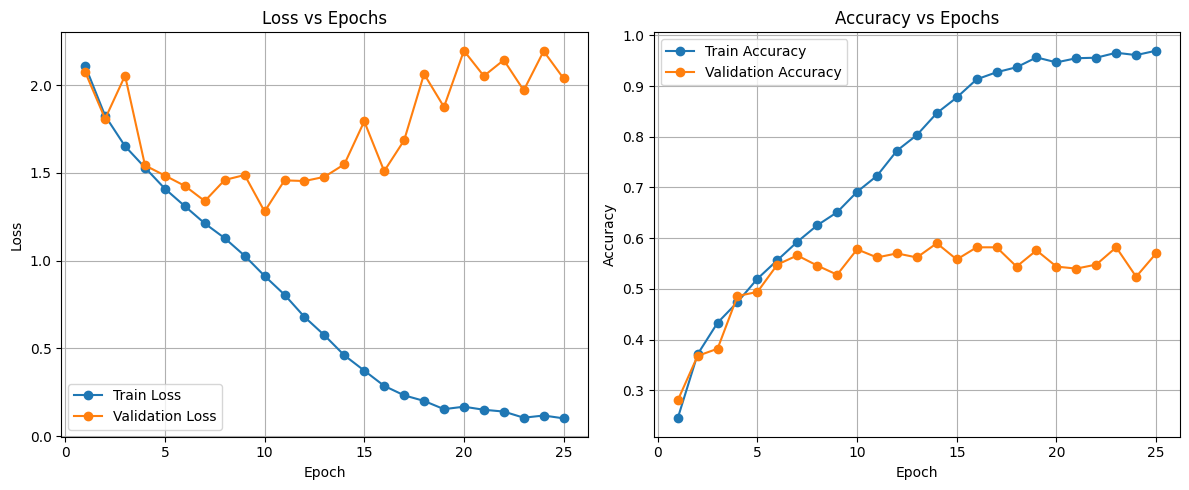

In [65]:
plot_training_curves(train_losses_bab, val_losses_bab, train_accs_bab, val_accs_bab)

### Вариант C: ELU

In [66]:
model_BAC = ResNet18_Version_BA(
    num_classes=10,
    activation="ELU",
    use_maxpool=True
).to(device)

optimizer_bac = torch.optim.Adam(model_BAC.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses_bac, val_losses_bac, train_accs_bac, val_accs_bac = train_model(model_BAC, train_loader, val_loader, criterion, optimizer_bac, device, 'model_bac.pth', 25)


Epoch [1/25]


Train Loss: 2.1271 | Train Acc: 0.2360 || Val Loss: 2.0161 | Val Acc: 0.2960
 Сохранена лучшая модель с точностью 29.60%

Epoch [2/25]


Train Loss: 1.9336 | Train Acc: 0.3240 || Val Loss: 1.9161 | Val Acc: 0.3560
 Сохранена лучшая модель с точностью 35.60%

Epoch [3/25]


Train Loss: 1.8352 | Train Acc: 0.3648 || Val Loss: 1.7860 | Val Acc: 0.3900
 Сохранена лучшая модель с точностью 39.00%

Epoch [4/25]


Train Loss: 1.7578 | Train Acc: 0.3856 || Val Loss: 1.8085 | Val Acc: 0.4120
 Сохранена лучшая модель с точностью 41.20%

Epoch [5/25]


Train Loss: 1.6900 | Train Acc: 0.4166 || Val Loss: 1.7967 | Val Acc: 0.4020

Epoch [6/25]


Train Loss: 1.6263 | Train Acc: 0.4346 || Val Loss: 1.7013 | Val Acc: 0.4180
 Сохранена лучшая модель с точностью 41.80%

Epoch [7/25]


Train Loss: 1.5541 | Train Acc: 0.4662 || Val Loss: 1.6102 | Val Acc: 0.4560
 Сохранена лучшая модель с точностью 45.60%

Epoch [8/25]


Train Loss: 1.4926 | Train Acc: 0.4916 || Val Loss: 1.5426 | Val Acc: 0.4800
 Сохранена лучшая модель с точностью 48.00%

Epoch [9/25]


Train Loss: 1.4333 | Train Acc: 0.5182 || Val Loss: 1.4143 | Val Acc: 0.5280
 Сохранена лучшая модель с точностью 52.80%

Epoch [10/25]


Train Loss: 1.3871 | Train Acc: 0.5314 || Val Loss: 1.5306 | Val Acc: 0.5160

Epoch [11/25]


Train Loss: 1.3374 | Train Acc: 0.5540 || Val Loss: 1.3509 | Val Acc: 0.5640
 Сохранена лучшая модель с точностью 56.40%

Epoch [12/25]


Train Loss: 1.2751 | Train Acc: 0.5782 || Val Loss: 1.4306 | Val Acc: 0.5360

Epoch [13/25]


Train Loss: 1.2180 | Train Acc: 0.5834 || Val Loss: 1.3700 | Val Acc: 0.5460

Epoch [14/25]


Train Loss: 1.1684 | Train Acc: 0.6054 || Val Loss: 1.4799 | Val Acc: 0.5240

Epoch [15/25]


Train Loss: 1.1241 | Train Acc: 0.6304 || Val Loss: 1.4404 | Val Acc: 0.5580

Epoch [16/25]


Train Loss: 1.0712 | Train Acc: 0.6396 || Val Loss: 1.3837 | Val Acc: 0.5660
 Сохранена лучшая модель с точностью 56.60%

Epoch [17/25]


Train Loss: 1.0139 | Train Acc: 0.6620 || Val Loss: 1.2592 | Val Acc: 0.6020
 Сохранена лучшая модель с точностью 60.20%

Epoch [18/25]


Train Loss: 0.9656 | Train Acc: 0.6766 || Val Loss: 1.3524 | Val Acc: 0.5880

Epoch [19/25]


Train Loss: 0.9002 | Train Acc: 0.6958 || Val Loss: 1.3740 | Val Acc: 0.5620

Epoch [20/25]


Train Loss: 0.8503 | Train Acc: 0.7162 || Val Loss: 1.4045 | Val Acc: 0.5820

Epoch [21/25]


Train Loss: 0.8015 | Train Acc: 0.7388 || Val Loss: 1.3760 | Val Acc: 0.5700

Epoch [22/25]


Train Loss: 0.7439 | Train Acc: 0.7488 || Val Loss: 1.4564 | Val Acc: 0.5700

Epoch [23/25]


Train Loss: 0.6648 | Train Acc: 0.7756 || Val Loss: 1.4098 | Val Acc: 0.5920

Epoch [24/25]


Train Loss: 0.6123 | Train Acc: 0.8024 || Val Loss: 1.4459 | Val Acc: 0.5880

Epoch [25/25]


Train Loss: 0.5233 | Train Acc: 0.8204 || Val Loss: 1.5607 | Val Acc: 0.5760


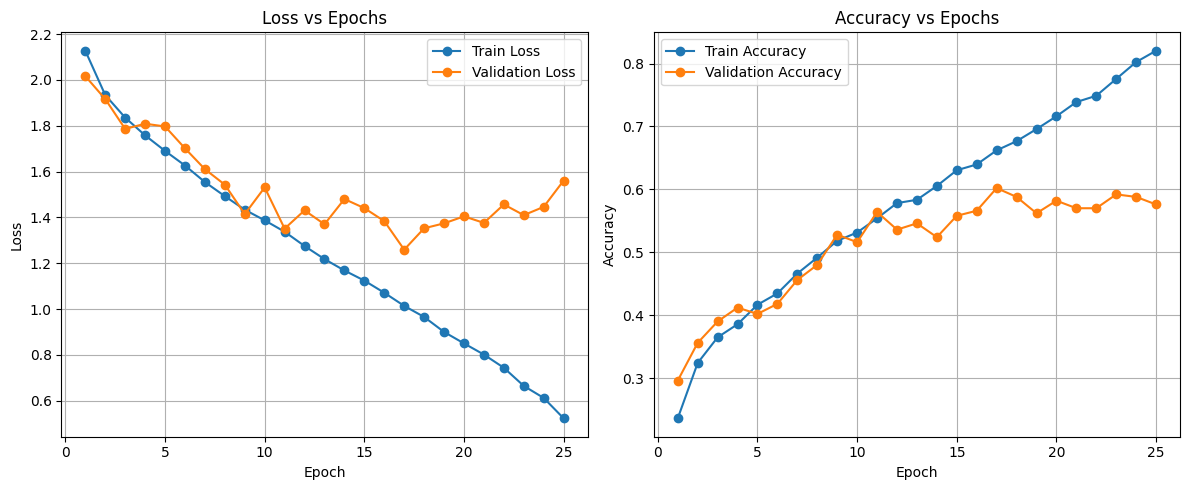

In [67]:
plot_training_curves(train_losses_bac, val_losses_bac, train_accs_bac, val_accs_bac)

### Вариант D: GELU

In [68]:
model_BAD = ResNet18_Version_BA(
    num_classes=10,
    activation="GELU",
    use_maxpool=True
).to(device)

optimizer_bad = torch.optim.Adam(model_BAD.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses_bad, val_losses_bad, train_accs_bad, val_accs_bad = train_model(model_BAD, train_loader, val_loader, criterion, optimizer_bad, device, 'model_bad.pth', 25)


Epoch [1/25]


Train Loss: 2.1219 | Train Acc: 0.2438 || Val Loss: 1.9405 | Val Acc: 0.3120
 Сохранена лучшая модель с точностью 31.20%

Epoch [2/25]


Train Loss: 1.8222 | Train Acc: 0.3634 || Val Loss: 1.7564 | Val Acc: 0.3960
 Сохранена лучшая модель с точностью 39.60%

Epoch [3/25]


Train Loss: 1.6331 | Train Acc: 0.4332 || Val Loss: 1.6530 | Val Acc: 0.4360
 Сохранена лучшая модель с точностью 43.60%

Epoch [4/25]


Train Loss: 1.4985 | Train Acc: 0.4862 || Val Loss: 1.5614 | Val Acc: 0.4680
 Сохранена лучшая модель с точностью 46.80%

Epoch [5/25]


Train Loss: 1.3737 | Train Acc: 0.5450 || Val Loss: 1.5020 | Val Acc: 0.4880
 Сохранена лучшая модель с точностью 48.80%

Epoch [6/25]


Train Loss: 1.2812 | Train Acc: 0.5744 || Val Loss: 1.6511 | Val Acc: 0.4920
 Сохранена лучшая модель с точностью 49.20%

Epoch [7/25]


Train Loss: 1.1708 | Train Acc: 0.6108 || Val Loss: 1.3782 | Val Acc: 0.5500
 Сохранена лучшая модель с точностью 55.00%

Epoch [8/25]


Train Loss: 1.0563 | Train Acc: 0.6428 || Val Loss: 1.2622 | Val Acc: 0.5980
 Сохранена лучшая модель с точностью 59.80%

Epoch [9/25]


Train Loss: 0.9452 | Train Acc: 0.6870 || Val Loss: 1.3792 | Val Acc: 0.5700

Epoch [10/25]


Train Loss: 0.8425 | Train Acc: 0.7184 || Val Loss: 1.2094 | Val Acc: 0.6180
 Сохранена лучшая модель с точностью 61.80%

Epoch [11/25]


Train Loss: 0.6930 | Train Acc: 0.7726 || Val Loss: 1.3267 | Val Acc: 0.5860

Epoch [12/25]


Train Loss: 0.5502 | Train Acc: 0.8182 || Val Loss: 1.3835 | Val Acc: 0.5740

Epoch [13/25]


Train Loss: 0.4286 | Train Acc: 0.8638 || Val Loss: 1.3650 | Val Acc: 0.5860

Epoch [14/25]


Train Loss: 0.3226 | Train Acc: 0.8966 || Val Loss: 1.3923 | Val Acc: 0.5860

Epoch [15/25]


Train Loss: 0.2299 | Train Acc: 0.9282 || Val Loss: 1.5151 | Val Acc: 0.6000

Epoch [16/25]


Train Loss: 0.1885 | Train Acc: 0.9416 || Val Loss: 1.5301 | Val Acc: 0.6060

Epoch [17/25]


Train Loss: 0.1787 | Train Acc: 0.9434 || Val Loss: 1.6262 | Val Acc: 0.5900

Epoch [18/25]


Train Loss: 0.1445 | Train Acc: 0.9546 || Val Loss: 1.6588 | Val Acc: 0.6040

Epoch [19/25]


Train Loss: 0.1476 | Train Acc: 0.9522 || Val Loss: 1.8157 | Val Acc: 0.5880

Epoch [20/25]


Train Loss: 0.1231 | Train Acc: 0.9642 || Val Loss: 1.8135 | Val Acc: 0.5820

Epoch [21/25]


Train Loss: 0.1117 | Train Acc: 0.9668 || Val Loss: 1.8981 | Val Acc: 0.5700

Epoch [22/25]


Train Loss: 0.0817 | Train Acc: 0.9776 || Val Loss: 1.6446 | Val Acc: 0.6080

Epoch [23/25]


Train Loss: 0.0878 | Train Acc: 0.9700 || Val Loss: 1.9853 | Val Acc: 0.5760

Epoch [24/25]


Train Loss: 0.1050 | Train Acc: 0.9684 || Val Loss: 1.9038 | Val Acc: 0.6180

Epoch [25/25]


Train Loss: 0.0547 | Train Acc: 0.9846 || Val Loss: 1.7747 | Val Acc: 0.6120


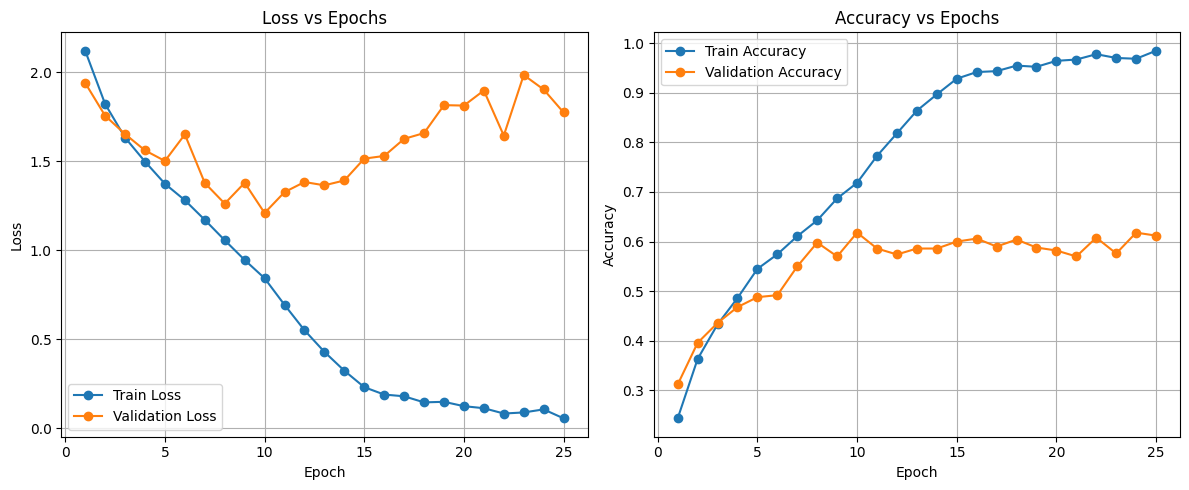

In [69]:
plot_training_curves(train_losses_bad, val_losses_bad, train_accs_bad, val_accs_bad)

RELU сошлась где-то на 11 эпохе  
LeakyRelu - на 10  
ElU - на 17  
GELU - примерно на 10

При этом RELU выбила максимальное значение vall acc 62.2 против 61.8 у GELU.  
При этом график ELU намного более плавный.  

**В качестве лучшей метрики признаем RELU**

# Часть 4: Финальная модель и тестирование


## 4.1: Создание финальной модели

In [ ]:
model_BA = ResNet18_Version_BA(
    num_classes=10,
    activation="relu",
    use_maxpool=True
).to(device)

optimizer_ba = torch.optim.Adam(model_BA.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses_ba, val_losses_ba, train_accs_ba, val_accs_ba = train_model(model_BA, train_loader, val_loader, criterion, optimizer_ba, device, 'model_ba.pth')

In [86]:
model_final = ResNet18_Version_BA(
    num_classes=10,
    activation="relu",
    use_maxpool=True
).to(device)

optimizer_final = torch.optim.Adam(model_final.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses_final, val_losses_final, train_accs_final, val_accs_final = train_model(model_final, train_loader, val_loader, criterion, optimizer_final, device, 'model_final.pth', 35)


Epoch [1/35]


Train Loss: 2.0556 | Train Acc: 0.2808 || Val Loss: 1.9578 | Val Acc: 0.3480
 Сохранена лучшая модель с точностью 34.80%

Epoch [2/35]


Train Loss: 1.7902 | Train Acc: 0.3852 || Val Loss: 1.9579 | Val Acc: 0.3420

Epoch [3/35]


Train Loss: 1.6415 | Train Acc: 0.4370 || Val Loss: 1.7227 | Val Acc: 0.4500
 Сохранена лучшая модель с точностью 45.00%

Epoch [4/35]


Train Loss: 1.5235 | Train Acc: 0.4746 || Val Loss: 1.7560 | Val Acc: 0.4200

Epoch [5/35]


Train Loss: 1.4174 | Train Acc: 0.5182 || Val Loss: 1.6382 | Val Acc: 0.4680
 Сохранена лучшая модель с точностью 46.80%

Epoch [6/35]


Train Loss: 1.3167 | Train Acc: 0.5516 || Val Loss: 1.4719 | Val Acc: 0.5020
 Сохранена лучшая модель с точностью 50.20%

Epoch [7/35]


Train Loss: 1.2277 | Train Acc: 0.5836 || Val Loss: 1.4387 | Val Acc: 0.5320
 Сохранена лучшая модель с точностью 53.20%

Epoch [8/35]


Train Loss: 1.1402 | Train Acc: 0.6098 || Val Loss: 1.7049 | Val Acc: 0.4700

Epoch [9/35]


Train Loss: 1.0262 | Train Acc: 0.6548 || Val Loss: 1.3613 | Val Acc: 0.5620
 Сохранена лучшая модель с точностью 56.20%

Epoch [10/35]


Train Loss: 0.9160 | Train Acc: 0.6900 || Val Loss: 1.2914 | Val Acc: 0.5920
 Сохранена лучшая модель с точностью 59.20%

Epoch [11/35]


Train Loss: 0.7955 | Train Acc: 0.7346 || Val Loss: 1.3910 | Val Acc: 0.5340

Epoch [12/35]


Train Loss: 0.6762 | Train Acc: 0.7778 || Val Loss: 1.3588 | Val Acc: 0.5580

Epoch [13/35]


Train Loss: 0.5531 | Train Acc: 0.8140 || Val Loss: 1.3501 | Val Acc: 0.5780

Epoch [14/35]


Train Loss: 0.4363 | Train Acc: 0.8540 || Val Loss: 1.7105 | Val Acc: 0.5280

Epoch [15/35]


Train Loss: 0.3400 | Train Acc: 0.8904 || Val Loss: 1.5741 | Val Acc: 0.5660

Epoch [16/35]


Train Loss: 0.2554 | Train Acc: 0.9168 || Val Loss: 1.7369 | Val Acc: 0.5740

Epoch [17/35]


Train Loss: 0.2279 | Train Acc: 0.9274 || Val Loss: 1.7390 | Val Acc: 0.5600

Epoch [18/35]


Train Loss: 0.1920 | Train Acc: 0.9360 || Val Loss: 1.9111 | Val Acc: 0.5440

Epoch [19/35]


Train Loss: 0.1763 | Train Acc: 0.9452 || Val Loss: 2.0071 | Val Acc: 0.5320

Epoch [20/35]


Train Loss: 0.1108 | Train Acc: 0.9686 || Val Loss: 1.9937 | Val Acc: 0.5620

Epoch [21/35]


Train Loss: 0.1367 | Train Acc: 0.9586 || Val Loss: 2.0532 | Val Acc: 0.5600

Epoch [22/35]


Train Loss: 0.1313 | Train Acc: 0.9604 || Val Loss: 2.1054 | Val Acc: 0.5580

Epoch [23/35]


Train Loss: 0.1256 | Train Acc: 0.9586 || Val Loss: 2.2889 | Val Acc: 0.5200

Epoch [24/35]


Train Loss: 0.1128 | Train Acc: 0.9624 || Val Loss: 2.1099 | Val Acc: 0.5640

Epoch [25/35]


Train Loss: 0.1077 | Train Acc: 0.9658 || Val Loss: 2.4802 | Val Acc: 0.5280

Epoch [26/35]


Train Loss: 0.0952 | Train Acc: 0.9692 || Val Loss: 2.0557 | Val Acc: 0.5560

Epoch [27/35]


Train Loss: 0.0816 | Train Acc: 0.9738 || Val Loss: 2.6174 | Val Acc: 0.4980

Epoch [28/35]


Train Loss: 0.0980 | Train Acc: 0.9694 || Val Loss: 2.7525 | Val Acc: 0.5160

Epoch [29/35]


Train Loss: 0.0851 | Train Acc: 0.9726 || Val Loss: 2.1402 | Val Acc: 0.5720

Epoch [30/35]


Train Loss: 0.0716 | Train Acc: 0.9792 || Val Loss: 2.3102 | Val Acc: 0.5300

Epoch [31/35]


Train Loss: 0.0700 | Train Acc: 0.9762 || Val Loss: 2.4761 | Val Acc: 0.5280

Epoch [32/35]


Train Loss: 0.0875 | Train Acc: 0.9702 || Val Loss: 2.2009 | Val Acc: 0.5780

Epoch [33/35]


Train Loss: 0.0727 | Train Acc: 0.9788 || Val Loss: 2.2951 | Val Acc: 0.5560

Epoch [34/35]


Train Loss: 0.0519 | Train Acc: 0.9810 || Val Loss: 2.3969 | Val Acc: 0.5440

Epoch [35/35]


Train Loss: 0.0673 | Train Acc: 0.9798 || Val Loss: 2.3167 | Val Acc: 0.5720


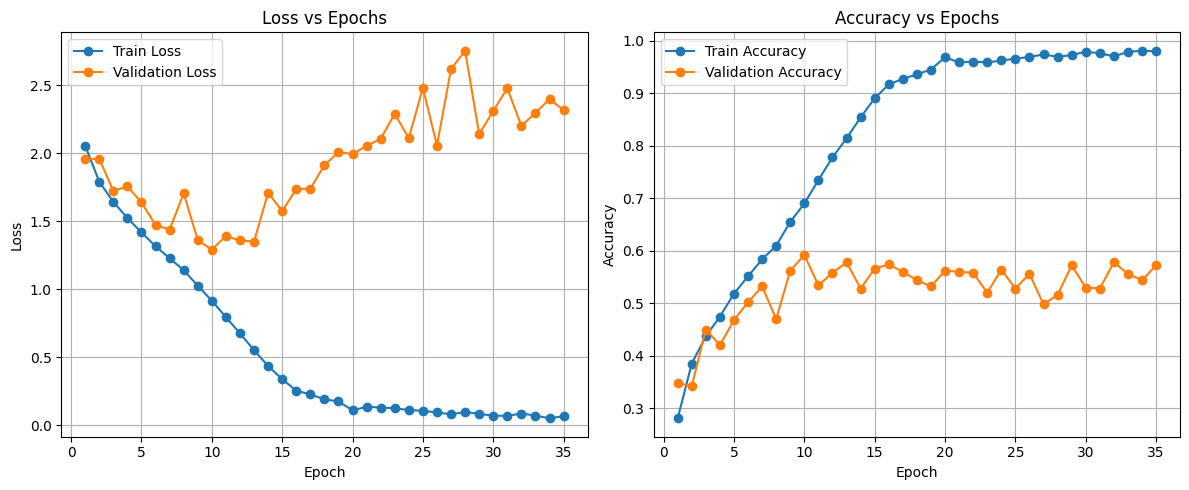

In [87]:
plot_training_curves(train_losses_final, val_losses_final, train_accs_final, val_accs_final)

***Сейчас почему-то совсем иначе обучился, не выбил 64%. Загружу в качестве финальной лучшую модель - model_ba.pth***

## 4.2: Тестирование на test set

In [88]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet18_Version_BA(num_classes=10, activation="relu").to(device)
model.load_state_dict(torch.load("model_ba.pth", map_location=device))
model.eval()


ResNet18_Version_BA(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (block1_1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU(inplace=True)
  )
  (block2_1): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_s

In [89]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Classification report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

Classification Report:

              precision    recall  f1-score   support

   n02106662       0.49      0.60      0.54        50
   n01882714       0.76      0.62      0.68        50
   n02124075       0.62      0.66      0.64        50
   n02132136       0.51      0.80      0.62        50
   n02395406       0.54      0.38      0.45        50
   n02410509       0.80      0.64      0.71        50
   n02415577       0.58      0.60      0.59        50
   n02423022       0.75      0.72      0.73        50
   n02480495       0.71      0.70      0.71        50
   n02509815       0.79      0.68      0.73        50

    accuracy                           0.64       500
   macro avg       0.66      0.64      0.64       500
weighted avg       0.66      0.64      0.64       500

Confusion Matrix:
 [[30  1  5  3  4  1  1  2  0  3]
 [ 5 31  3  2  2  0  2  1  3  1]
 [ 6  0 33  3  1  0  6  0  1  0]
 [ 1  0  0 40  1  0  3  1  2  2]
 [ 5  3  3 11 19  4  4  1  0  0]
 [ 3  0  0  7  2 32  4  0  2  0]


In [90]:
accuracy = (all_preds == all_labels).mean()
print(f"Test Accuracy: {accuracy*100:.2f}%")


Test Accuracy: 64.00%


## 4.3 Визуальный анализ

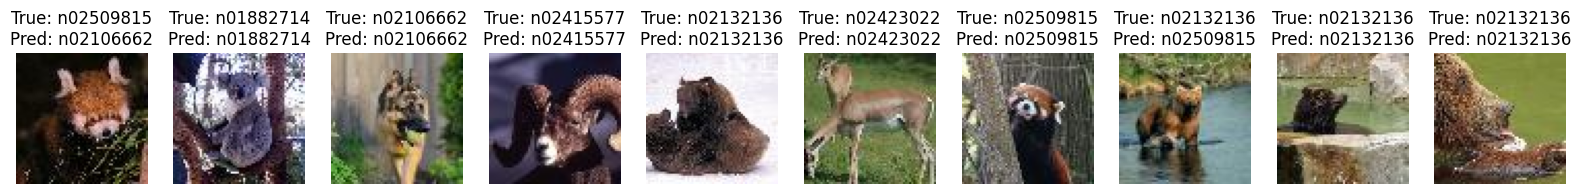

In [91]:
# Выбираем 10 случайных индексов
indices = random.sample(range(len(val_loader.dataset)), 10)

plt.figure(figsize=(20, 4))

for i, idx in enumerate(indices):
    image, label = val_loader.dataset[idx]
    input_img = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_img)
        pred = output.argmax(dim=1).item()

    plt.subplot(1, 10, i + 1)
    # Тензор (C,H,W) → numpy (H,W,C)
    img_np = image.permute(1, 2, 0).cpu().numpy()
    # Нормализуем обратно для отображения
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)

    plt.imshow(img_np)
    plt.axis("off")
    plt.title(f"True: {classes[label]}\nPred: {classes[pred]}")

plt.show()

## 4.4 Сравнительная таблица

In [95]:
final_table = [
    ['Этап', 'Конфигурация', 'Параметры', 'Val Accuracy', 'Train Accuracy'],
    ['Baseline', 'Базовая модель', 5.21, 53.2, 95.4],
    ['3.1-A', '32→64→128→256', 2.80, 55.0, 91.5],
    ['3.1-B', '64→128→256', 2.78, 58.4, 80.6],
    ['3.2-A', '[1,1,1] блоков', 1.23, 64.0, 84.6],
    ['3.2-B', '[2,2,2] блоков', 2.78, 58.4, 80.6],
    ['3.2-C', '[3,3,3] блоков', 4.33, 57.6, 64.8],
    ['3.3-A', 'ReLU', 1.23, 64.0, 84.6],
    ['3.3-B', 'LeakyReLU', 1.23, 59.0, 84.7],
    ['3.3-C', 'ELU', 1.23, 60.2, 66.2],
    ['3.3-D', 'GELU', 1.23, 61.8, 71.8],
    ['Final', 'Лучшая конфигурация', 1.23, 64.0, 84.6]
]

In [100]:
pd.DataFrame(final_table[1:], columns=final_table[0])

,Этап,Конфигурация,Параметры,Val Accuracy,Train Accuracy
0,Baseline,Базовая модель,5.21,53.2,95.4
1,3.1-A,32→64→128→256,2.80,55.0,91.5
2,3.1-B,64→128→256,2.78,58.4,80.6
3,3.2-A,"[1,1,1] блоков",1.23,64.0,84.6
4,3.2-B,"[2,2,2] блоков",2.78,58.4,80.6
5,3.2-C,"[3,3,3] блоков",4.33,57.6,64.8
6,3.3-A,ReLU,1.23,64.0,84.6
7,3.3-B,LeakyReLU,1.23,59.0,84.7
8,3.3-C,ELU,1.23,60.2,66.2
9,3.3-D,GELU,1.23,61.8,71.8


Выводы:  

Победителем является конфигурация:  
[1,1,1] residual-блок  
~1.23M параметров  


Train: 84.6  
Val:   64.0  
Разница - 20%, свидетельствует о наличии переобучения (но и все другие конфигурации переобучались). 